In [12]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import (
    auprc,
    factor_enrichment_gsea,
    get_gprofiler,
    read_aws_csv,
    read_aws_h5ad,
)

In [ ]:
# read in scETM results
adata = read_aws_h5ad("s3://pert-spectra/scETM_checkpoints/scetm_norman/fold_0.h5ad")
# read in pertspectra results to retrieve gene labels
ref_adata = read_aws_h5ad(
    "s3://pert-spectra/PertSpectra_checkpoints/pertspectra_norman/fold_0.h5ad"
)
adata.var_names = ref_adata.var_names

# Reconstruction

## Spearman Coefficient
- Spearman correlation between predicted and observed expression (on DE genes if available)

In [3]:
n_folds = 5
model_adatas = []
for n in range(0, n_folds):
    # new adata
    adata_n = adata.copy()
    # load model from checkpoint
    s3_dir = "s3://pert-spectra/scETM_checkpoints/"
    experiment_name = "scetm_norman/"
    model_name = f"fold_{n}.h5ad"
    m_adata = read_aws_h5ad(s3_dir + experiment_name + model_name)
    model_adatas.append(m_adata)

In [4]:
# iterate through all models and get the losses and correlations
# take the mean loss and correlation for the test set
from scipy.stats import spearmanr

test_corr_singles = []
test_corr_combos = []


for n in range(n_folds):
    adata_n = model_adatas[n]
    loss_weights = np.ones(adata_n.shape[0])

    for pert in adata_n.obs["perturbation_name"].unique():
        hold_idx = [
            i for i, x in enumerate(adata_n.obs["perturbation_name"]) if x == pert
        ]
        recon = adata_n[hold_idx].uns["recon"]
        # correlation
        mean_reconstruction = recon.mean(axis=0)
        mean_observed = np.squeeze(np.array(adata_n[hold_idx].X.mean(axis=0)))
        if ("+" in pert) and ("ctrl" not in pert):
            test_corr_combos.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )
        else:
            test_corr_singles.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )

0
(18547, 4990)
test
1
(20156, 4990)
test
2
(21410, 4990)
test
3
(20621, 4990)
test
4
(20752, 4990)
test


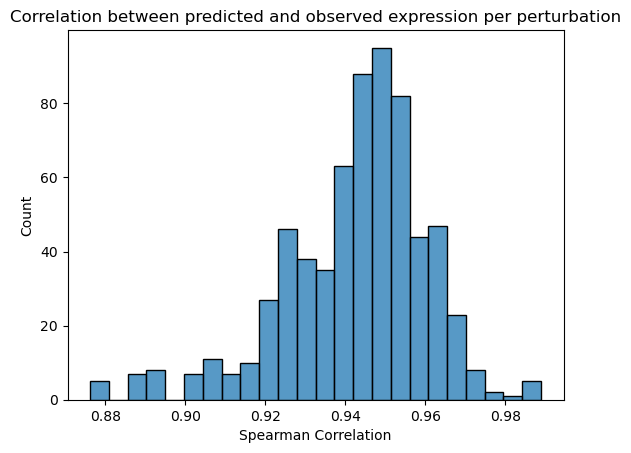

In [5]:
# plot train correlation distribution vs test correlation distribution
import seaborn as sns

test_corr = np.array(test_corr_singles + test_corr_combos)[:, 1].astype(float)
sns.histplot(test_corr, label="test_corr")
plt.title("Correlation between predicted and observed expression per perturbation")
plt.xlabel("Spearman Correlation")
plt.show()

In [6]:
np.savetxt(
    "figures/reconstruction_spearmans/scETM_norman_spearman_correlations.csv",
    test_corr,
    delimiter=",",
    fmt="%.2f",
)

# Perturbation Embedding Heatmap

## Hierarchical Clustering + Enrichment
- Perform enrichment tests (gprofiler) on hierarchical clustering of perturbation embeddings

In [ ]:
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform

# aggregate cell embeddings to perturbation embeddings
cell_emb = adata.uns["cell_emb"] @ adata.uns["topics"]
perts = []
pert_emb = []
for i in adata.obs["perturbation_name"].unique():
    if "+" not in i and i != "nan":
        perts.append(i)
        pert_emb.append(cell_emb[adata.obs["perturbation_name"] == i].mean(axis=0))
pert_emb = np.array(pert_emb)
pert_emb_df = pd.DataFrame(pert_emb, index=perts)

# Compute the pairwise distances
df = pert_emb_df.drop(index=["control"])

distance = "euclidean"
distances = pdist(df.values, metric=distance)

# Convert the distances into a square distance matrix
distance_matrix = pd.DataFrame(squareform(distances), index=df.index, columns=df.index)

# Compute the linkage matrix using the condensed distance matrix
linkage_matrix = linkage(distance_matrix, method="ward")

# Plot the dendrogram (optional)
dendro = dendrogram(linkage_matrix, no_plot=True)

# Assign clusters
max_d = 1.2  # Max distance for flat clusters
clusters = fcluster(linkage_matrix, max_d, criterion="distance")

# Create a color palette for clusters
palette = sns.color_palette("husl", len(np.unique(clusters)))

# Map each cluster id to a color
cluster_colors = [palette[i - 1] for i in clusters]

# Show the plot
plt.show()

clustermap = sns.clustermap(
    distance_matrix, cmap="viridis_r", row_colors=cluster_colors
)
clustermap.fig.suptitle(f"Pairwise {distance} distance of perturbation latent vectors")
# clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
# clustermap.cax.set_visible(False)
plt.show()

In [72]:
# extract clusters and perform gprofiler
index_names = list(distance_matrix.index)
cluster_df = pd.DataFrame({"Pert": index_names, "Cluster": clusters})
cluster_process = {}
for cluster_id in np.unique(clusters):
    points_in_cluster = cluster_df[cluster_df["Cluster"] == cluster_id]["Pert"].tolist()
    gprofiler_in = pd.DataFrame(points_in_cluster, columns=["gene_symbol"])
    res = get_gprofiler(gprofiler_in)
    cluster_process[cluster_id] = res[res["p_value"] <= 0.05]

In [ ]:
# Create descriptions for each cluster (for demonstration purpose)
cluster_descriptions = {
    1: "Protein tyrosine phosphatase activity",
    2: "",
    3: "protein serine/threonine kinase activity",
    4: "DNA-binding transcription factor activity, RNA polymerase II transcription",
    5: "MAPK activity, regulation of IRE1-mediated unfolded protein",
    6: "morphogenesis, DNA-binding transcription factor activity, transcription by RNA polymerase II",
    7: "negative regulation of ERBB signaling pathway",
    8: "MAPK activity, procentriole replication",
    9: "vesicle lumen",
    10: "collagen trimer",
    11: "DNA-binding transcription factor activity, RNA polymerase II transcription",
    12: "",
    13: "",
    14: "C/EBP complex",
}

# Create a consistent color palette
unique_clusters = sorted(np.unique(clusters))
palette = sns.color_palette("husl", len(unique_clusters))
cluster_colors = [palette[i - 1] for i in clusters]
cluster_colors = {cid: palette[i] for i, cid in enumerate(unique_clusters)}

# Create clustermap using consistent colors
row_colors = [cluster_colors[cid] for cid in clusters]
clustermap = sns.clustermap(
    distance_matrix, cmap="viridis_r", row_colors=[palette[i - 1] for i in clusters]
)
clustermap.savefig(
    "figures/figure_pngs/scETM_norman_clustermap.png", dpi=600, bbox_inches="tight"
)

# Prepare data for the table
cluster_data = {
    "Cluster ID": unique_clusters,
    "Description": [cluster_descriptions[cid] for cid in unique_clusters],
}

cluster_df = pd.DataFrame(cluster_data)

# Plot the table with colors matching the clustermap
fig, ax = plt.subplots(figsize=(18, 4))
ax.axis("off")
ax.axis("tight")

# Create table while applying the color to the row background
table = ax.table(
    cellText=cluster_df.values,
    colLabels=["Cluster ID", "Description"],
    cellColours=[[cluster_colors[cid]] * 2 for cid in cluster_df["Cluster ID"]],
    cellLoc="center",
    loc="center",
)

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig(
    "figures/figure_pngs/scETM_norman_clustermap_descriptions.png",
    dpi=600,
    bbox_inches="tight",
)
plt.show()

In [89]:
# save grpofiler results
with open(
    "figures/pert_embedding_cluster_gprofiler/scETM_norman_pert_emb_gprofiler.pickle",
    "wb",
) as handle:
    pickle.dump(cluster_process, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PR Curve+AUC
- AUCPR using prior graph as binary label

In [53]:
aucpr_df, f1_df, pr_dict = auprc(distance_matrix)
print(aucpr_df)
print(f1_df)
aucpr_df.to_csv("figures/pert_embedding_recall/scETM_norman_aucpr.csv")
f1_df.to_csv("figures/pert_embedding_recall/scETM_norman_f1.csv")

               AUC
StringDB  0.726058
CORUM     0.946866
                F1  Threshold
StringDB  0.820312        1.0
CORUM     0.972222        1.0


# Interpretability of our learned latent space

## Factor Enrichment
- GSEA on log transformed latent-by-gene factors
- Then associate each perturbation to its top latent factors

In [ ]:
factor_to_go = factor_enrichment_gsea(adata, np.abs(adata.uns["gene_emb"]), fdr=0.05)

In [ ]:
# filter and add description to processes
go_df = read_aws_csv("s3://pert-spectra/references/GO_to_Description.txt")
go_df.set_index("Term", inplace=True)
go_dict = go_df.to_dict()["Description"]

filtered_factor_to_go = {}
for i in factor_to_go:
    proc = factor_to_go[i]
    proc["descr"] = [go_dict[x] for x in proc["GO_ID"]]
    filtered_factor_to_go[i] = proc

In [ ]:
# save latent enrichment results
with open(
    "figures/factor_enrichments/scETM_norman_factor_enrichment.pickle", "wb"
) as handle:
    pickle.dump(filtered_factor_to_go, handle, protocol=pickle.HIGHEST_PROTOCOL)